In [1]:
from rayoptics.environment import *
import random
from copy import deepcopy
from scipy.optimize import minimize 
import numpy as np

2023-04-05 16:06:02.167008: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-05 16:06:02.185220: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-05 16:06:02.186335: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-05 16:06:02.413466: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: 

In [2]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.numpy import sqrt, copysign, sin
jax.config.update("jax_enable_x64", True)

In [3]:
isdark = False

In [4]:
def lens(f, R1, R2, d_L, wv, n, pupil_r, p = [0]):
    opm = OpticalModel()
    sm  = opm['seq_model']
    osp = opm['optical_spec']
    # pm = opm['parax_model']
    # em = opm['ele_model']
    # pt = opm['part_tree']
    # ar = opm['analysis_results']
    osp['pupil'] = PupilSpec(osp, key=['object', 'pupil'], value=pupil_r*2)
    osp['fov'] = FieldSpec(osp, key=['object', 'angle'], value=2.5, flds=[0., 0.707, 1.], is_relative=True)
    osp['wvls'] = WvlSpec([('F', 0.5), (wv, 1.0), ('C', 0.5)], ref_wl=1)

    opm.radius_mode = True

    sm.gaps[0].thi = 1
    remaining_height = f
    
    # the front surface of the lens is a sphere plus some radial polynomial defined by p
    sm.add_surface([R1, d_L, n, pupil_r])
    #print(R1)
    #print(p)
    sm.ifcs[sm.cur_surface].profile = RadialPolynomial(r=R1, coefs=p)
    sm.set_stop()
    # the back surface of the lens is a sphere 
    sm.add_surface([R2, 0])

    sm.gaps[-1].thi = remaining_height - d_L
    opm.update_model()
    return sm

In [5]:
number_of_colors = 3
hexadecimal_alphabets = '0123456789ABCDEF'
random.seed(2)
color = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in
range(6)]) for i in range(number_of_colors)]
    
def visualize(sm):
    thi = sm.gaps[0].thi
    fig = plt.figure(figsize=(6,6), dpi=300)
    ax = fig.add_subplot(111)
    offsets = np.linspace(-pupil_r, pupil_r,30)

    idx = 0
    all_focus_loc_y = [] # all locations of the proposed point
    for ray_angle in np.linspace(-max_angle, max_angle, number_of_colors):
        focus_loc_y = []
        inc_angle = np.pi*ray_angle
        valid_ray_count = 0
        for ray_offset in offsets:
            si = np.sin(inc_angle)
            cs = np.cos(inc_angle)
            tn = np.tan(inc_angle)
            st_coord = np.array([0,ray_offset - tn*thi,0])
            st_dir = np.array([0,si,cs])
            output = trace(sm, st_coord, st_dir, wvl=wv)
            pt_photosensor = output[0][-1][0]
            if np.abs(pt_photosensor[1]) <= 5:
                valid_ray_count += 1
                focus_loc_y.append(pt_photosensor[1])
                y = []
                z = []
                z_bias = 0
                j = 0
                for pt in output[0][0::]:
                    y.append(pt[0][1])
                    z.append(pt[0][2]+z_bias)
                    if j < len(sm.gaps):
                        z_bias += sm.gaps[j].thi
                        j += 1
                plt.plot(z, y, '-', linewidth=0.25, color=color[idx])
                plt.plot(z[1::], y[1::], '*', markersize=1, color=color[idx])
        idx += 1
        all_focus_loc_y.append(np.median(focus_loc_y))
    ax.set_aspect('equal')
    plt.xlabel('mm')
    plt.ylabel('mm')
    
    return all_focus_loc_y

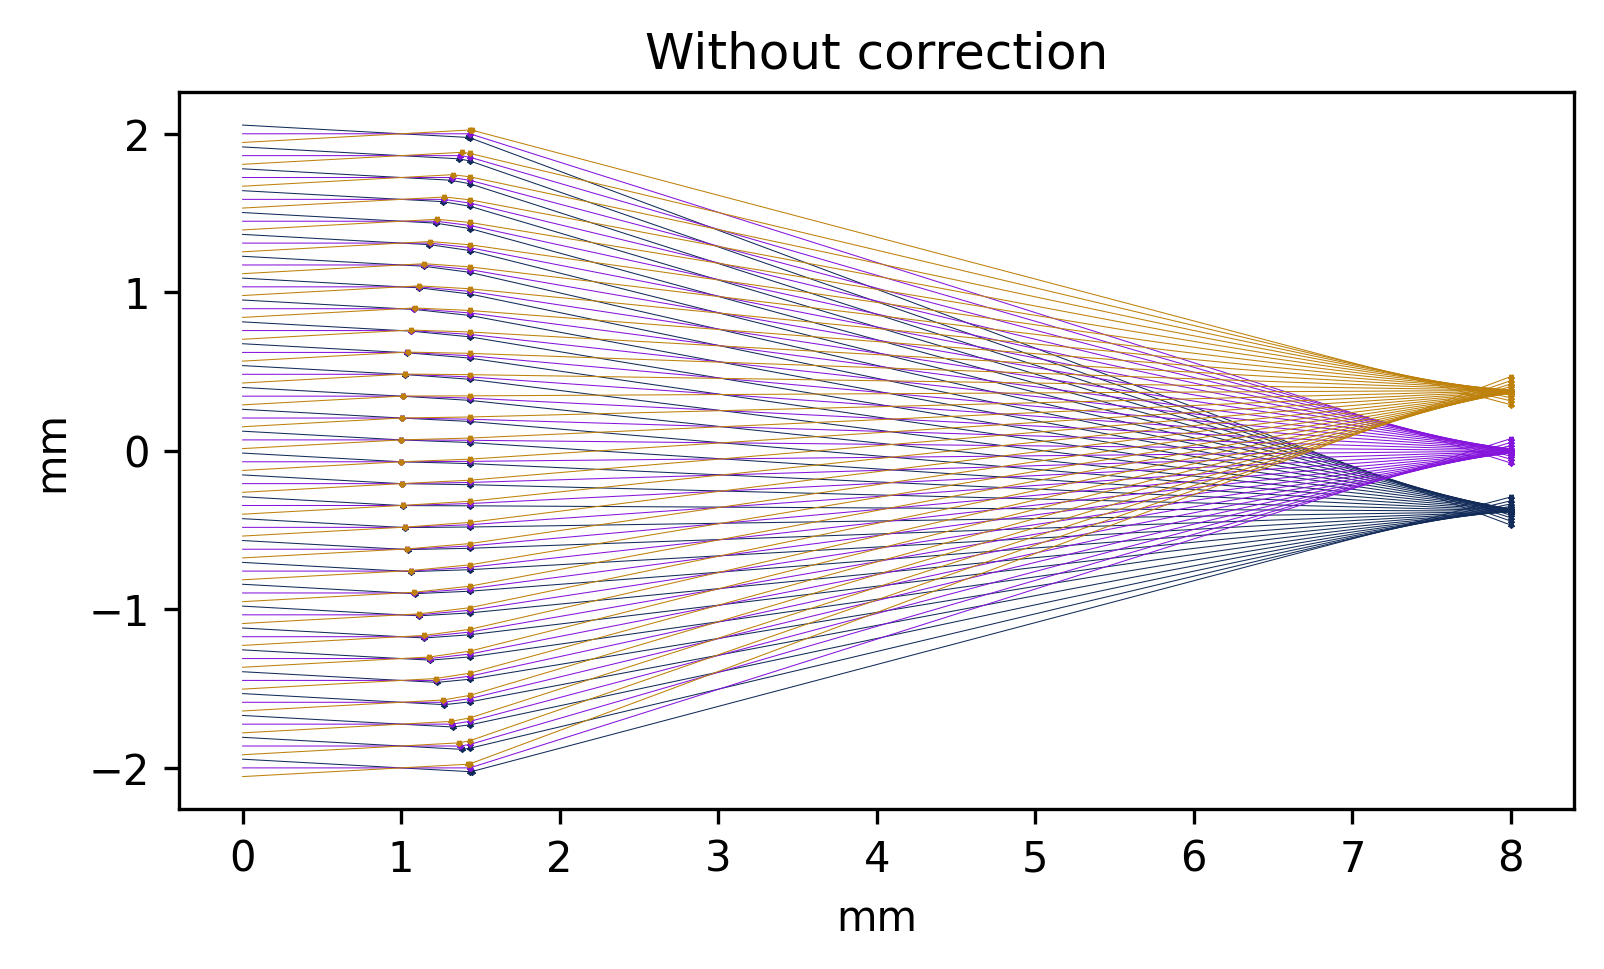

In [6]:
# This cell simulates a lens without any correction
# you can see the light from the same incident angle (same color) 
# is not well focused
f = 7 # focal length in mm
wv = 400.5618
pupil_r = 2
n = 1.69 # refractive index
R2 = -100000 # radius of the first surface, mm
R1 = (n-1) * f # radius of the second surface, mm
f = 1/((n - 1) * (1/R1 - 1/R2)) # lens maker equation
d_L1 = (np.abs(R1) - np.sqrt(R1**2 - pupil_r**2)) 
d_L2 = (np.abs(R2) - np.sqrt(R2**2 - pupil_r**2))
d_L = d_L1 + d_L2 # lens thickness

max_angle = 1/180*np.pi # max incident angle, rad

sm = lens(f, R1, R2, d_L, wv, n, pupil_r)
visualize(sm)
plt.title('Without correction')
plt.savefig('L1-no-correction.pdf')

In [7]:
import jax.numpy as jnp

In [8]:

def mydotfunc(d,p):
    return d[0] * p[0] + d[1] * p[1] + d[2] * p[2]

In [9]:
def isNaN(num):
    return num!=num

In [10]:
def mynanmeanfunc_prev(num):
    #num = num[~jnp.isnan(num)]
    num = [v for v in num if ~jnp.isnan(v)]   #function contains if statement which is not compatible with jit
    
    sum_num = 0
    #non_nan_total = 0
    for t in num:
        sum_num = sum_num + t


    avg = sum_num / len(num)
    
    return avg

In [11]:
#n = mynanmeanfunc_prev(a)
#print(n)

In [12]:
# def mynanmeanfunc(num):

    
#     sum_num = 0
#     non_nan_total = 0
#     for t in num:                                      #function with python for loop very slow with jit
#         sum_num = sum_num + jnp.nan_to_num(t,nan=0)
#         non_nan_total = non_nan_total + (1-jnp.isnan(t))

#     avg = sum_num / non_nan_total
    
#     return avg
        

In [13]:
from jax import lax

In [14]:
def mynanmeanfunc(num):
    
    sum_num = 0                                   #function with jax lax.fori_loop
    non_nan_total = 0
    def our_sum(a, b):
        return a + jnp.nan_to_num(b, nan=0)
    body_func = lambda t,sum_num : sum_num + jnp.nan_to_num(jnp.take(num, t),nan=0)
    body_funcc = lambda t,non_nan_total : non_nan_total + (1-jnp.isnan(t))
    #sum_num = sum_num + jnp.nan_to_num(num,nan=0)
    #non_nan_total = non_nan_total + (1-jnp.isnan(num))
    # lax.fori_loop(0,5,test_func,0)
    print(num)
    sum_num = lax.scan(our_sum, 0, num)[0]
    #lax.fori_loop(0,num, body_funcc,0)
    #avg = body_func/body_funcc 
    
    #return avg

In [15]:
def mynanmeanfunc(num):

    

    body_func = lambda i, num:num+i

    lax.fori_loop(0,5,body_func,0)

    avg = body_func 
    
    return avg

In [16]:
def objective_function(p):
    # the objective function calculates the loss give lens with shape parameter p
    sm = lens(f, R1, R2, d_L, wv, n, pupil_r, p)
    
    thi = sm.gaps[0].thi
    number_of_colors = 5
    hexadecimal_alphabets = '0123456789ABCDEF'
    color = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in
    range(6)]) for i in range(number_of_colors)]
    offsets = jnp.linspace(-pupil_r, pupil_r,100) #changed

    # The objective is to make light rays coming from the same direction 
    # to focus at the same location on the photosensor plane
    # Thus, the objective function penalizes the differences between 
    # the deflected ray direction dir_L and the desired ray direction dir_L_target
    idx = 0
    loss = []
    # loop over every incident angle ray_angle
    for ray_angle in jnp.linspace(-max_angle, max_angle, number_of_colors, dtype=np.float64):  #changed
        inc_angle = jnp.pi*ray_angle #changed
        # loop over every location on the lens ray_offset
        for ray_offset in offsets:
            si = jnp.sin(inc_angle) #changed
            cs = jnp.cos(inc_angle) #changed
            tn = jnp.tan(inc_angle) #changed
            st_coord = jnp.array([0,ray_offset - tn*thi,0]) #changed
            st_dir = jnp.array([0,si,cs]) #changed
            output = trace(sm, st_coord, st_dir, wvl=wv)
    
            pt_L = deepcopy(output[0][2][0])
            y=sm.gaps[1].thi #changed
            pt_L = pt_L.at[2].add(y) #changed
            #pt_L[2] = pt_L[2] + sm.gaps[1].thi
            dir_L = deepcopy(output[0][2][1])
            #dir_L_target = np.array([0, (f)*tn-pt_L[1], (f) - pt_L[2]])
            #dir_L_target = jnp.array([0, (f)*tn-pt_L[1], (f) - pt_L[2]])
            #dir_L_target = [0, (f)*tn-pt_L[1], (f) - pt_L[2]] #changed
            #dir_L_target[0] =0
            #dir_L_target[1] =(f)*tn-pt_L[1]
            #dir_L_target[2] = (f) - pt_L[2]
            dir_L_target = jnp.stack([0, (f)*tn-pt_L[1], (f) - pt_L[2]]) #changed
            dir_L_target = dir_L_target / sqrt(jnp.sum(dir_L_target**2))
            # dir_L_target is the desired ray direction after deflected by the lens
            #dir_L_target = dir_L_target / np.sqrt(np.sum(dir_L_target**2))
            #dir_L_target[0] = dir_L_target[0]/sqrt(jnp.sum(dir_L_target[0]**2,dir_L_target[1]**2,dir_L_target[2]**2)) #chnaged
            
            # dir_L_target[0] = dir_L_target[0]/sqrt((dir_L_target[0]**2)+(dir_L_target[1]**2)+(dir_L_target[2]**2))
            # dir_L_target[1] = dir_L_target[1]/sqrt((dir_L_target[0]**2)+(dir_L_target[1]**2)+(dir_L_target[2]**2))
            # dir_L_target[2] = dir_L_target[2]/sqrt((dir_L_target[0]**2)+(dir_L_target[1]**2)+(dir_L_target[2]**2))

            
            # calculating the dot product of the actual ray direction and the 
            # target ray direction after deflection, it is 1 when the direction
            # completely aligns, and 0 when perpendicular
            # dotprod = mydotfunc(dir_L, dir_L_target)
            dotprod = jnp.dot(dir_L, dir_L_target)
            
            # print(dir_L)
            # print(dir_L_target)
            # print(dotprod)
            # print('...')
            loss.append(1-dotprod)
    
    # average over all rays
    loss = jnp.stack(loss, 0)
    loss = jnp.nanmean(loss)
    # loss = mynanmeanfunc(loss)#changed
    print(loss)
    return loss

In [17]:
def objective_function_fori(p):
    # the objective function calculates the loss give lens with shape parameter p
    sm = lens(f, R1, R2, d_L, wv, n, pupil_r, p)
    
    thi = sm.gaps[0].thi
    number_of_colors = 5
    hexadecimal_alphabets = '0123456789ABCDEF'
    color = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in
    range(6)]) for i in range(number_of_colors)]
    offsets = jnp.linspace(-pupil_r, pupil_r,100) #changed

    # The objective is to make light rays coming from the same direction 
    # to focus at the same location on the photosensor plane
    # Thus, the objective function penalizes the differences between 
    # the deflected ray direction dir_L and the desired ray direction dir_L_target
    idx = 0
    loss = []

    ray_angle = jnp.linspace(-max_angle, max_angle, number_of_colors, dtype=np.float64)
    ray_offset = offsets
    all_ray_angle, all_ray_offset = jnp.meshgrid(ray_angle, ray_offset)
    all_ray_angle = all_ray_angle.flatten()
    all_ray_offset = all_ray_offset.flatten()
    all_ray = jnp.stack([all_ray_angle, all_ray_offset], -1)

    def calcLoss(total_loss, ray):
        ray_angle = ray[0]
        ray_offset = ray[1]

        inc_angle = jnp.pi*ray_angle #changed

        si = jnp.sin(inc_angle) #changed
        cs = jnp.cos(inc_angle) #changed
        tn = jnp.tan(inc_angle) #changed
        st_coord = jnp.array([0,ray_offset - tn*thi,0]) #changed
        st_dir = jnp.array([0,si,cs]) #changed
        output = trace(sm, st_coord, st_dir, wvl=wv)

        pt_L = deepcopy(output[0][2][0])
        y=sm.gaps[1].thi #changed
        pt_L = pt_L.at[2].add(y) #changed
        dir_L = deepcopy(output[0][2][1])
        dir_L_target = jnp.stack([0, (f)*tn-pt_L[1], (f) - pt_L[2]]) #changed
        dir_L_target = dir_L_target / sqrt(jnp.sum(dir_L_target**2))

        # calculating the dot product of the actual ray direction and the 
        # target ray direction after deflection, it is 1 when the direction
        # completely aligns, and 0 when perpendicular
        dotprod = jnp.dot(dir_L, dir_L_target)

        loss = 1 - dotprod
        total_loss = total_loss + loss
        # print(loss)

        return total_loss, loss
        
    all_loss, loss = lax.scan(calcLoss, 0, all_ray)

    # average over all rays
    loss = jnp.nanmean(loss)
    # loss = mynanmeanfunc(loss)#changed
    print(loss)
    return loss

In [18]:
# This function calculates the gradient of the loss with respect to p
# using finite difference
# It is very costly when p is high dimensional, thus we need auto-differentiation
def custom_grad(p, step=0.000001):
    dldp = np.zeros(len(p))
    step = step
    for i in range(len(p)):
        dp = np.zeros(len(p))
        dp[i] += step
        dldp[i] = (objective_function(p+dp) - objective_function(p-dp))/(step*2)
    return dldp

In [19]:
np.random.seed(1)
p = (np.random.rand(5))/100
print(p)

[4.17022005e-03 7.20324493e-03 1.14374817e-06 3.02332573e-03
 1.46755891e-03]


In [20]:
objective_function(p)

0.0020350910086212866


DeviceArray(0.00203509, dtype=float64)

In [21]:
objective_function_fori(p)

0.0020350910086212658


DeviceArray(0.00203509, dtype=float64)

In [28]:
custom_grad(p)

0.002035117828820512
0.0020350641888406164
0.002035175481452467
0.0020350065377812187
0.002035301283781276
0.002034880743849486
0.0020355720148983133
0.002034610054602303
0.002036146955382975
0.002034035316353209


array([0.02681999, 0.08447184, 0.21026997, 0.48098015, 1.05581951])

In [29]:
gradObjFunc = grad(objective_function)

In [30]:
gradObjFunc(p)

Traced<ConcreteArray(0.0020350910086212866, dtype=float64)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(0.00203509, dtype=float64)
  tangent = Traced<ShapedArray(float64[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float64[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f75c1cfc480>, in_tracers=(Traced<ConcreteArray([False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False F

DeviceArray([0.02681999, 0.08447184, 0.21026997, 0.48098015, 1.05581952],            dtype=float64)

In [31]:
jit_gradObjFunc = jit(grad(objective_function_fori))

In [32]:
jit_gradObjFunc(p)

Traced<ShapedArray(float64[])>with<JVPTrace(level=2/1)> with
  primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
  tangent = Traced<ShapedArray(float64[])>with<JaxprTrace(level=1/1)> with
    pval = (ShapedArray(float64[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f7641161150>, in_tracers=(Traced<ShapedArray(bool[500]):JaxprTrace(level=1/1)>, Traced<ShapedArray(float64[500]):JaxprTrace(level=1/1)>, Traced<ShapedArray(float64[]):JaxprTrace(level=1/1)>, Traced<ShapedArray(float64[500]):JaxprTrace(level=1/1)>), out_tracer_refs=[<weakref at 0x7f75c4ac2610; to 'JaxprTracer' at 0x7f75c4ac1a80>], out_avals=[ShapedArray(float64[])], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'nanmean', 'donated_invars': (False, False, False, False), 'inline': False, 'keep_unused': False, 'call_jaxpr': { lambda ; a:bool[500] b:f64[500] c:f64[] d:f64[500]. let
    e:f64[] = xla_call[
      call_jaxpr={ lambda ; f:bool[500] g:f64[500] h:f64[50

DeviceArray([0.02681999, 0.08447184, 0.21026997, 0.48098015, 1.05581952],            dtype=float64)

In [33]:
#p = (np.random.rand(5))/100
%timeit jit_gradObjFunc(p)

376 µs ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [34]:
# optimize p using non-gradient based optimization, 'Nelder-Mead' is the simplex method
# the loss is printed out, you can see the drop of the loss
#p=np.zeros(5)
p_opt = minimize(objective_function_fori, p, method='BFGS', jac=jit_gradObjFunc, options={'disp':True, 'maxiter': 1000},tol=1e-8)
#print(p_opt)

0.0020350910086212658
0.1804886540343954
0.0020350910086212658
0.1804886540343954
0.17746837578912658
0.184937650469526
0.12498719915503867
2.679979615761696e-05
6.18977718620275e-05
1.509849105230554e-06
1.131203218027732e-06
5.775946205148763e-07
4.1251758029248185e-07
4.110204238301218e-07
4.1086664415912464e-07
4.1073082766485136e-07
4.104853882813675e-07
4.1005188948695095e-07
4.0937090530768214e-07
4.0884986765421517e-07
4.087366434524231e-07
4.0869415900868234e-07
4.0869144931088285e-07
4.086884880307728e-07
4.086832013090458e-07
4.0867344005035553e-07
4.086552653255193e-07
4.0862162513310983e-07
4.085605334041009e-07
4.0845363237251855e-07
4.0827877501481424e-07
4.080239647925588e-07
4.077706009915083e-07
4.074744263080632e-07
4.0734402302322615e-07
4.0732228319106945e-07
4.073212735928866e-07
4.073212598385556e-07
4.0732125979503485e-07
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 31
         Function evaluations: 39
    

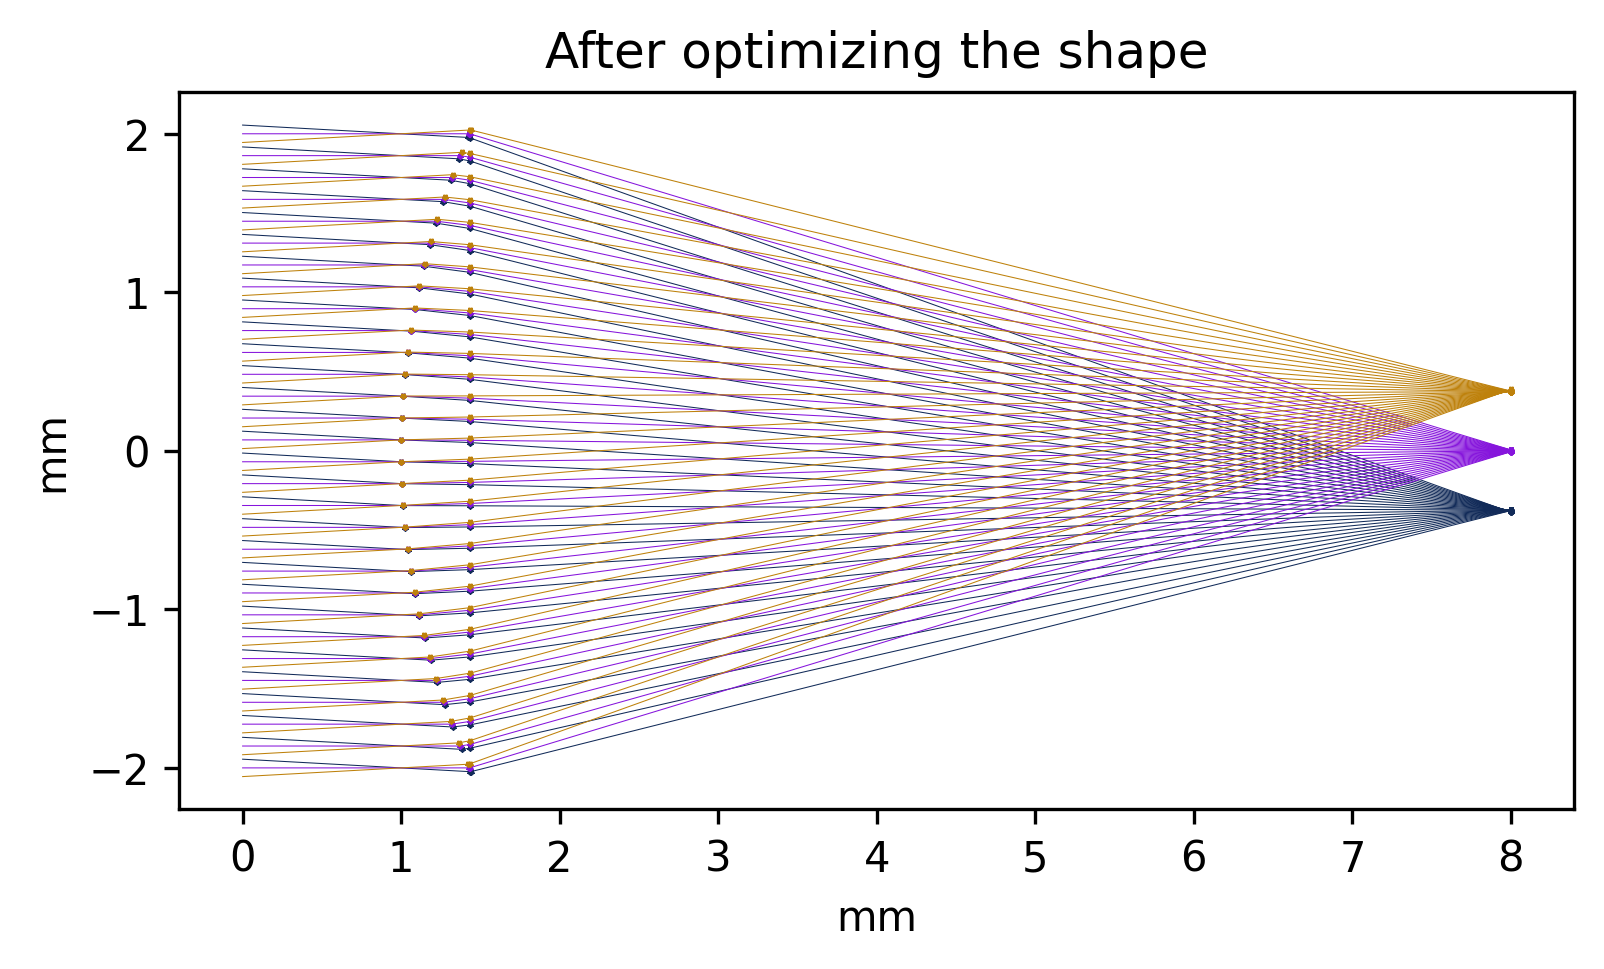

In [35]:
# plot the ray tracing result after optimization
sm = lens(f, R1, R2, d_L, wv, n, pupil_r,p_opt.x)
visualize(sm)
plt.title('After optimizing the shape')
plt.savefig('Corrected.pdf')